# Araçların Teknik Özelliklerinin Analizi Ve Fiyat Tahminlemesi

## 1. Proje Amacı
Bu projenin temel amacı, araçların teknik özelliklerinin analizini gerçekleştirerek **araçların filaytını (price)** tahmin eden bir makine öğrenmesi modeli geliştirmektir.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import joblib
import scipy.stats as stats  
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb 
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import shap
import datetime
from warnings import filterwarnings
filterwarnings('ignore') 

In [2]:
ad1 = pd.read_csv("Datasets/audi.csv")
df1 = ad1.copy()
df1['model'] = 'Audi_' + df1['model']

In [3]:
ad2 = pd.read_csv("Datasets/bmw.csv")
df2 = ad2.copy()
df2['model'] = 'bmw_' + df2['model']

In [4]:
ad3 = pd.read_csv("Datasets/ford.csv")
df3 = ad3.copy()
df3['model'] = 'ford_' + df3['model']

In [5]:
ad4 = pd.read_csv("Datasets/hyundi.csv")
df4 = ad4.copy()
df4['model'] = 'hyundi_' + df4['model']

In [6]:
df4.head()

,model,year,price,transmission,mileage,fuelType,tax(£),mpg,engineSize
0,hyundi_ I20,2017,7999,Manual,17307,Petrol,145,58.9,1.2
1,hyundi_ Tucson,2016,14499,Automatic,25233,Diesel,235,43.5,2.0
2,hyundi_ Tucson,2016,11399,Manual,37877,Diesel,30,61.7,1.7
3,hyundi_ I10,2016,6499,Manual,23789,Petrol,20,60.1,1.0
4,hyundi_ IX35,2015,10199,Manual,33177,Diesel,160,51.4,2.0


In [7]:
df4.rename(columns={"tax(£)": "tax"}, inplace=True)

In [8]:
ad5 = pd.read_csv("Datasets/mercedes.csv")
df5 = ad5.copy()
df5['model'] = 'mercedes_' + df5['model']

In [9]:
ad6 = pd.read_csv("Datasets/skoda.csv")
df6 = ad6.copy()
df6['model'] = 'skoda_' + df6['model']

In [10]:
ad7 = pd.read_csv("Datasets/toyota.csv")
df7 = ad7.copy()
df7['model'] = 'toyota_' + df7['model']

In [11]:
ad8 = pd.read_csv("Datasets/vw.csv")
df8 = ad8.copy()
df8['model'] = 'vw_' + df8['model']

In [12]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8])
df.to_csv('merged_file.csv', index=False)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85555 entries, 0 to 15156
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         85555 non-null  object 
 1   year          85555 non-null  int64  
 2   price         85555 non-null  int64  
 3   transmission  85555 non-null  object 
 4   mileage       85555 non-null  int64  
 5   fuelType      85555 non-null  object 
 6   tax           85555 non-null  int64  
 7   mpg           85555 non-null  float64
 8   engineSize    85555 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 6.5+ MB


In [14]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Audi_ A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,Audi_ A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,Audi_ A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,Audi_ A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,Audi_ A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


## 2. Veri Seti Tanımı
Veri setimiz 85555 arabaya ait verilerini içermektedir. sütunlar şunlardır:
* **model:** Araçların modelleri.
* **year:** Araçların Üretim yılı.
* **price(Hedef Değişken):** Araçların fiyatı.
* **transmission:** Araçların şanzıman tipi.
* **mileage:** Araçların mevcut kilometre durumu.
* **fuelType:** Araçların tükettği yakıt tipi.
* **tax:** Araçların vergi yükümlülüğü.
* **mpg(Miles Per Gallon):** Bir aracın 1 galon yakıtla kaç mil gidebildiğinin göstergesi.
* **engineSize:** Araçların motor hacmi.

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,85555.0,2017.108305,2.127201,1970.0,2016.0,2017.0,2019.0,2060.0
price,85555.0,17824.921793,10162.376307,495.0,10790.0,15700.0,21998.0,159999.0
mileage,85555.0,22988.745076,21312.435922,1.0,7041.0,17232.0,32345.0,323000.0
tax,85555.0,118.950733,64.404267,0.0,125.0,145.0,145.0,580.0
mpg,85555.0,55.745505,16.839501,0.3,47.1,55.4,62.8,470.8
engineSize,85555.0,1.702485,0.584701,0.0,1.2,1.6,2.0,6.6


In [16]:
for i in df.select_dtypes(include='object').columns:
    print(df[i].value_counts())
    print('****'*20)

model
ford_ Fiesta         6557
vw_ Golf             4863
ford_ Focus          4588
mercedes_ C Class    3747
vw_ Polo             3287
                     ... 
ford_ Ranger            1
Audi_ RS7               1
Audi_ A2                1
mercedes_220            1
mercedes_200            1
Name: count, Length: 173, dtype: int64
********************************************************************************
transmission
Manual       44465
Semi-Auto    22212
Automatic    18872
Other            6
Name: count, dtype: int64
********************************************************************************
fuelType
Petrol      44123
Diesel      38105
Hybrid       3076
Other         246
Electric        5
Name: count, dtype: int64
********************************************************************************


## 3. Özellik Mühendisliği (Feature Engineering)

In [17]:
current_year = datetime.datetime.now().year
df['age'] = 2026 - df['year']

In [18]:
# Yeni araçlar 0 yaş için bölen 1
df['mileage_per_year'] = df['mileage'] / df['age'].replace(0, 1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85555 entries, 0 to 15156
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   model             85555 non-null  object 
 1   year              85555 non-null  int64  
 2   price             85555 non-null  int64  
 3   transmission      85555 non-null  object 
 4   mileage           85555 non-null  int64  
 5   fuelType          85555 non-null  object 
 6   tax               85555 non-null  int64  
 7   mpg               85555 non-null  float64
 8   engineSize        85555 non-null  float64
 9   age               85555 non-null  int64  
 10  mileage_per_year  85555 non-null  float64
dtypes: float64(3), int64(5), object(3)
memory usage: 7.8+ MB


In [20]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,age,mileage_per_year
0,Audi_ A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,9,1748.333333
1,Audi_ A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,10,3620.300000
2,Audi_ A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,10,2994.600000
3,Audi_ A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,9,2883.555556
4,Audi_ A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,7,285.428571


## 4. Keşifçi Veri Analizi (EDA)

Sayısal değişkenlerin dağılımını ve uç değerleri (outliers) incelemek için Boxplot grafikleri kullanıyoruz.
* **Gözlem:** Aşağıdaki grafiklerde, özellikle *Avg_Daily_Usage_Hours* değişkeninde bazı öğrencilerin ortalamanın çok üzerinde kullanım yaptığını görebiliriz.
* **İlişki Analizi:** *Mental_Health_Score* ile *Addicted_Score* arasında ters bir korelasyon olması beklenebilir.

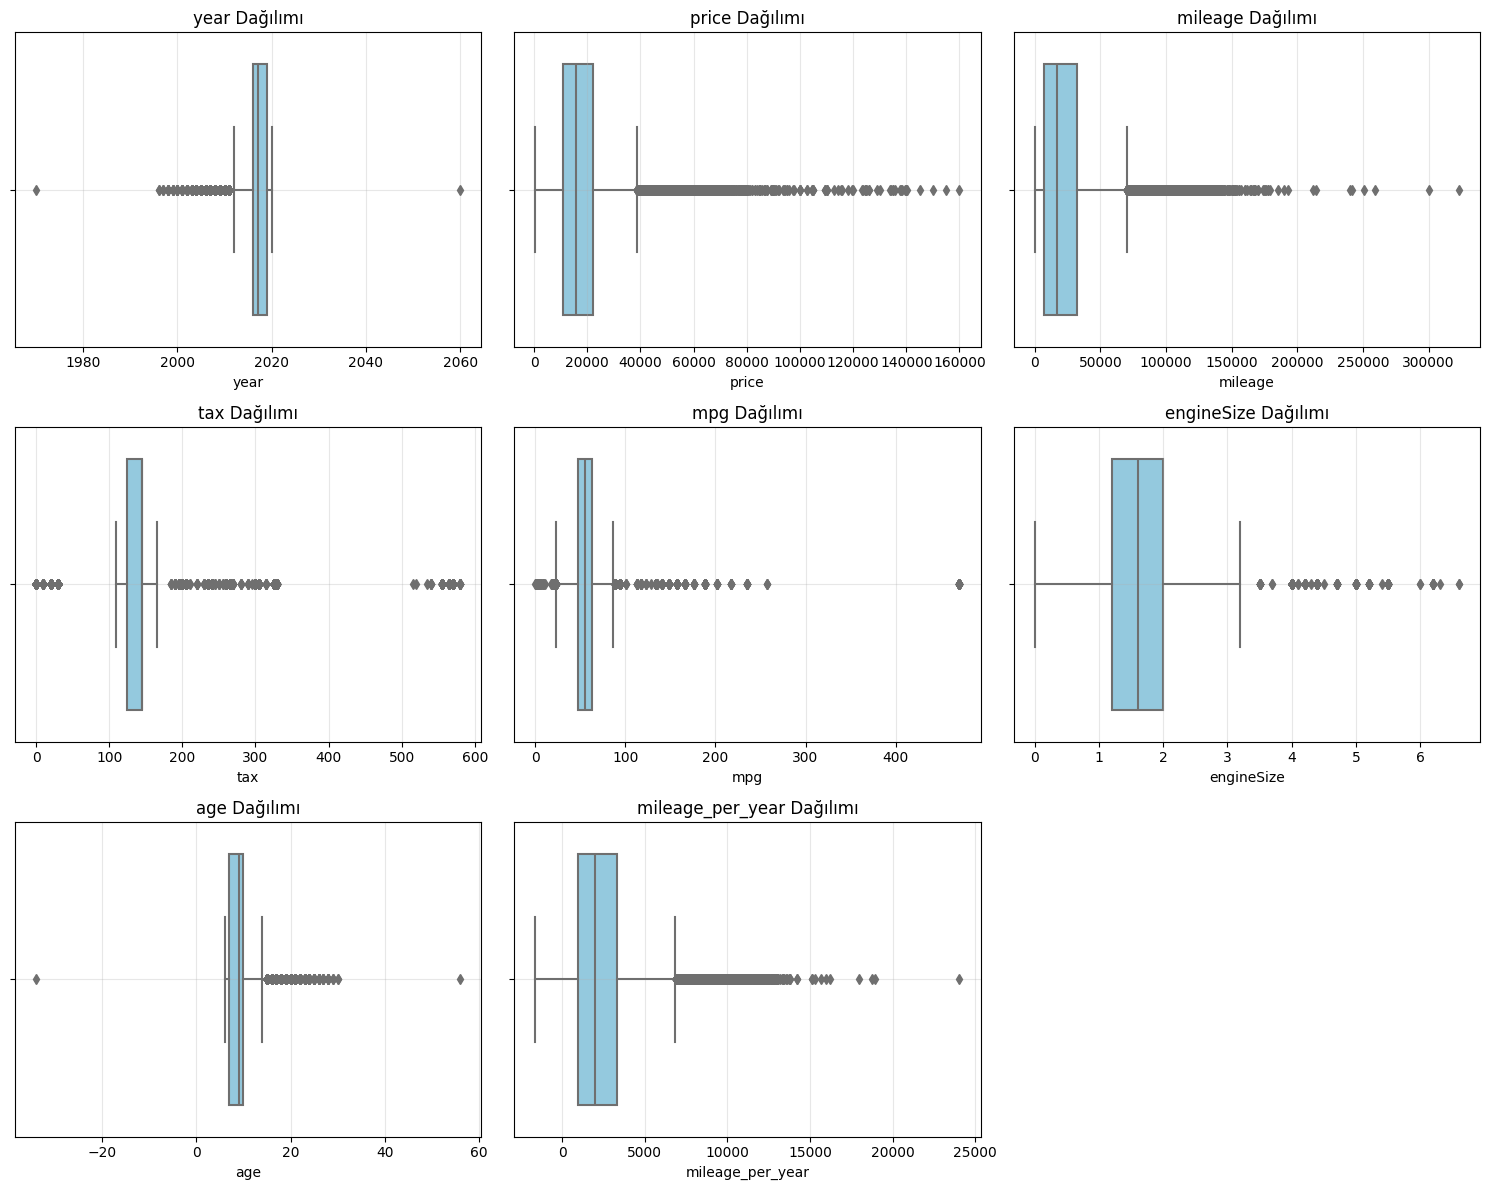

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

numeric_cols = df.select_dtypes(include=['number']).columns

num_plots = len(numeric_cols)
cols = 3 
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(15, rows * 4)) 

for i, column in enumerate(numeric_cols):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x=df[column], color='skyblue') 
    plt.title(f'{column} Dağılımı')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Yıl hatası: 2060 yılına ait ve 1970 e ait araçlar gözüküyor bu araçları temizleyeim
df = df[df['year'] <= 2026]
df = df[df['year'] >= 1980]

In [23]:
# motor hacmi 0 olan değerleri temizleyelim 
df = df[df['engineSize'] > 0]

In [24]:
# MPG hatası: 400 üzeri mpg değerleri genelde hatalı veri girişidir bunları da temizleyelim
df = df[df['mpg'] < 400]

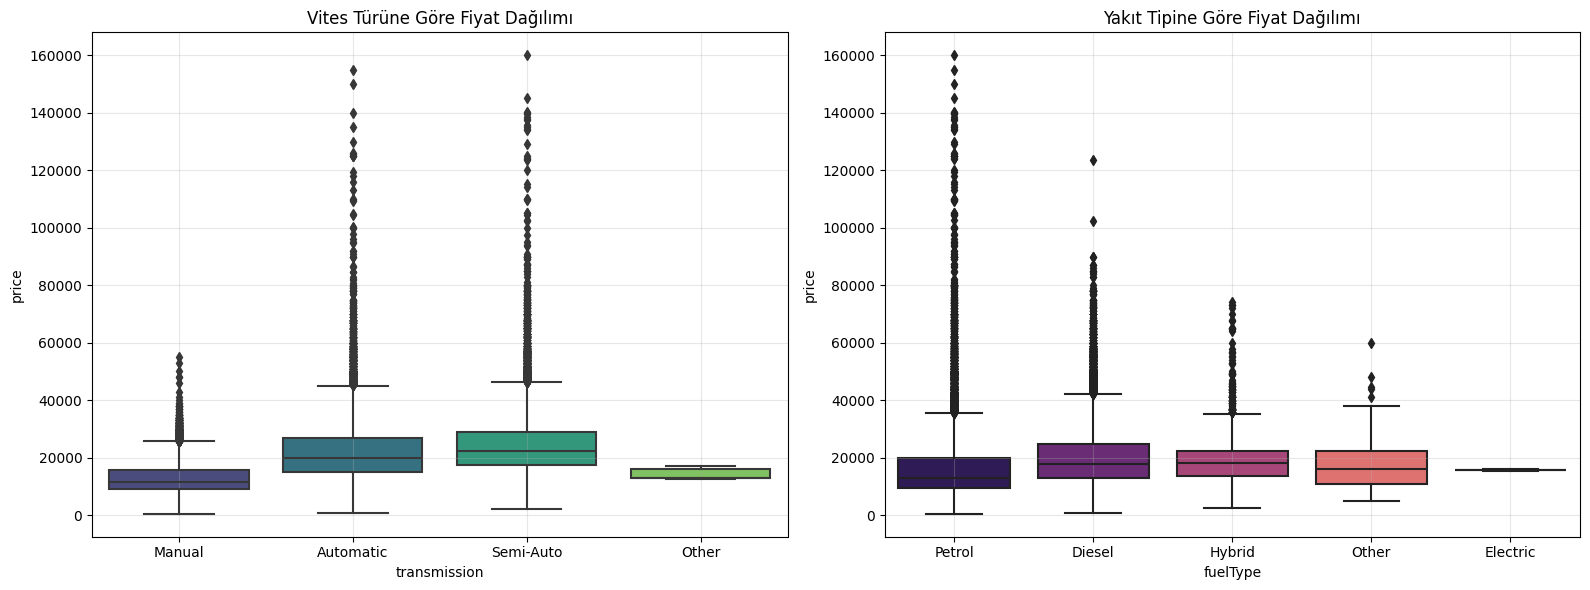

In [25]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='transmission', y='price', data=df, palette='viridis')
plt.title('Vites Türüne Göre Fiyat Dağılımı')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.boxplot(x='fuelType', y='price', data=df, palette='magma')
plt.title('Yakıt Tipine Göre Fiyat Dağılımı')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

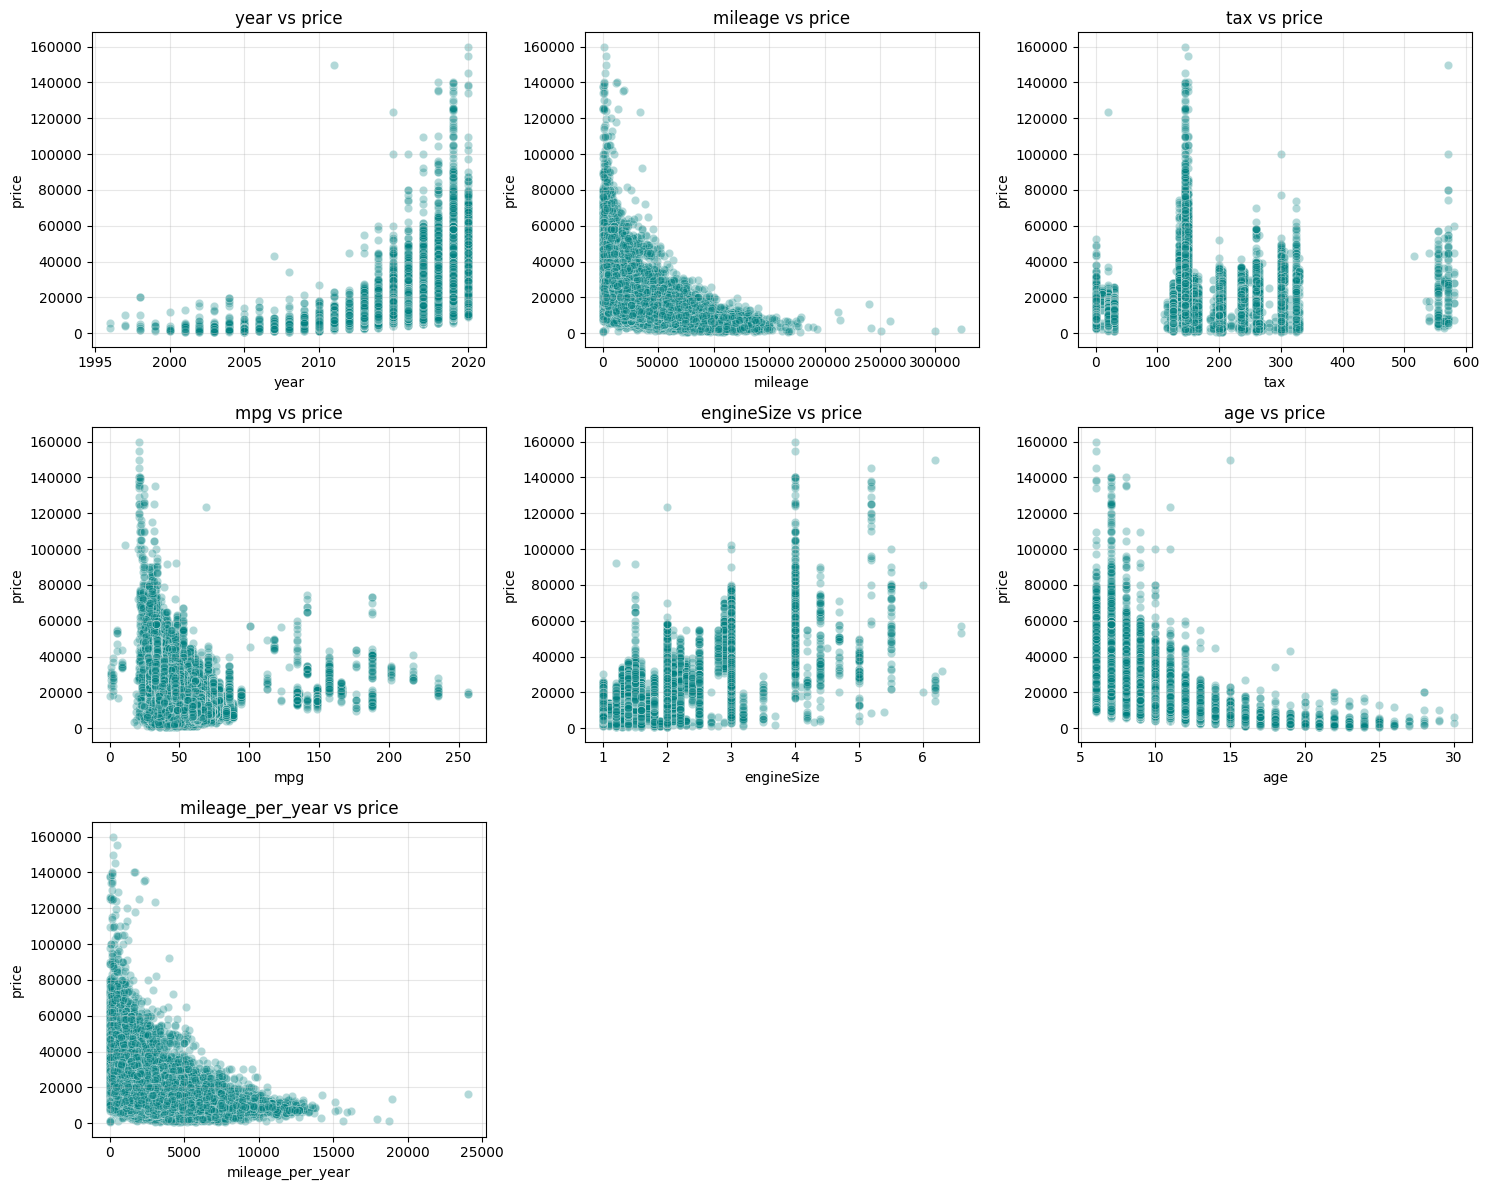

In [26]:
#her bir sütunun y ile korelasyon grafiği
import matplotlib.pyplot as plt
import seaborn as sns
import math

target_col = 'price'

numeric_cols = df.select_dtypes(include=['number']).columns
feature_cols = [col for col in numeric_cols if col != target_col]

num_plots = len(feature_cols)
cols = 3  
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(15, rows * 4))

for i, col in enumerate(feature_cols):
    plt.subplot(rows, cols, i + 1)
    
    sns.scatterplot(x=df[col], y=df[target_col], alpha=0.3, color='teal')
    
    plt.title(f'{col} vs {target_col}')
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

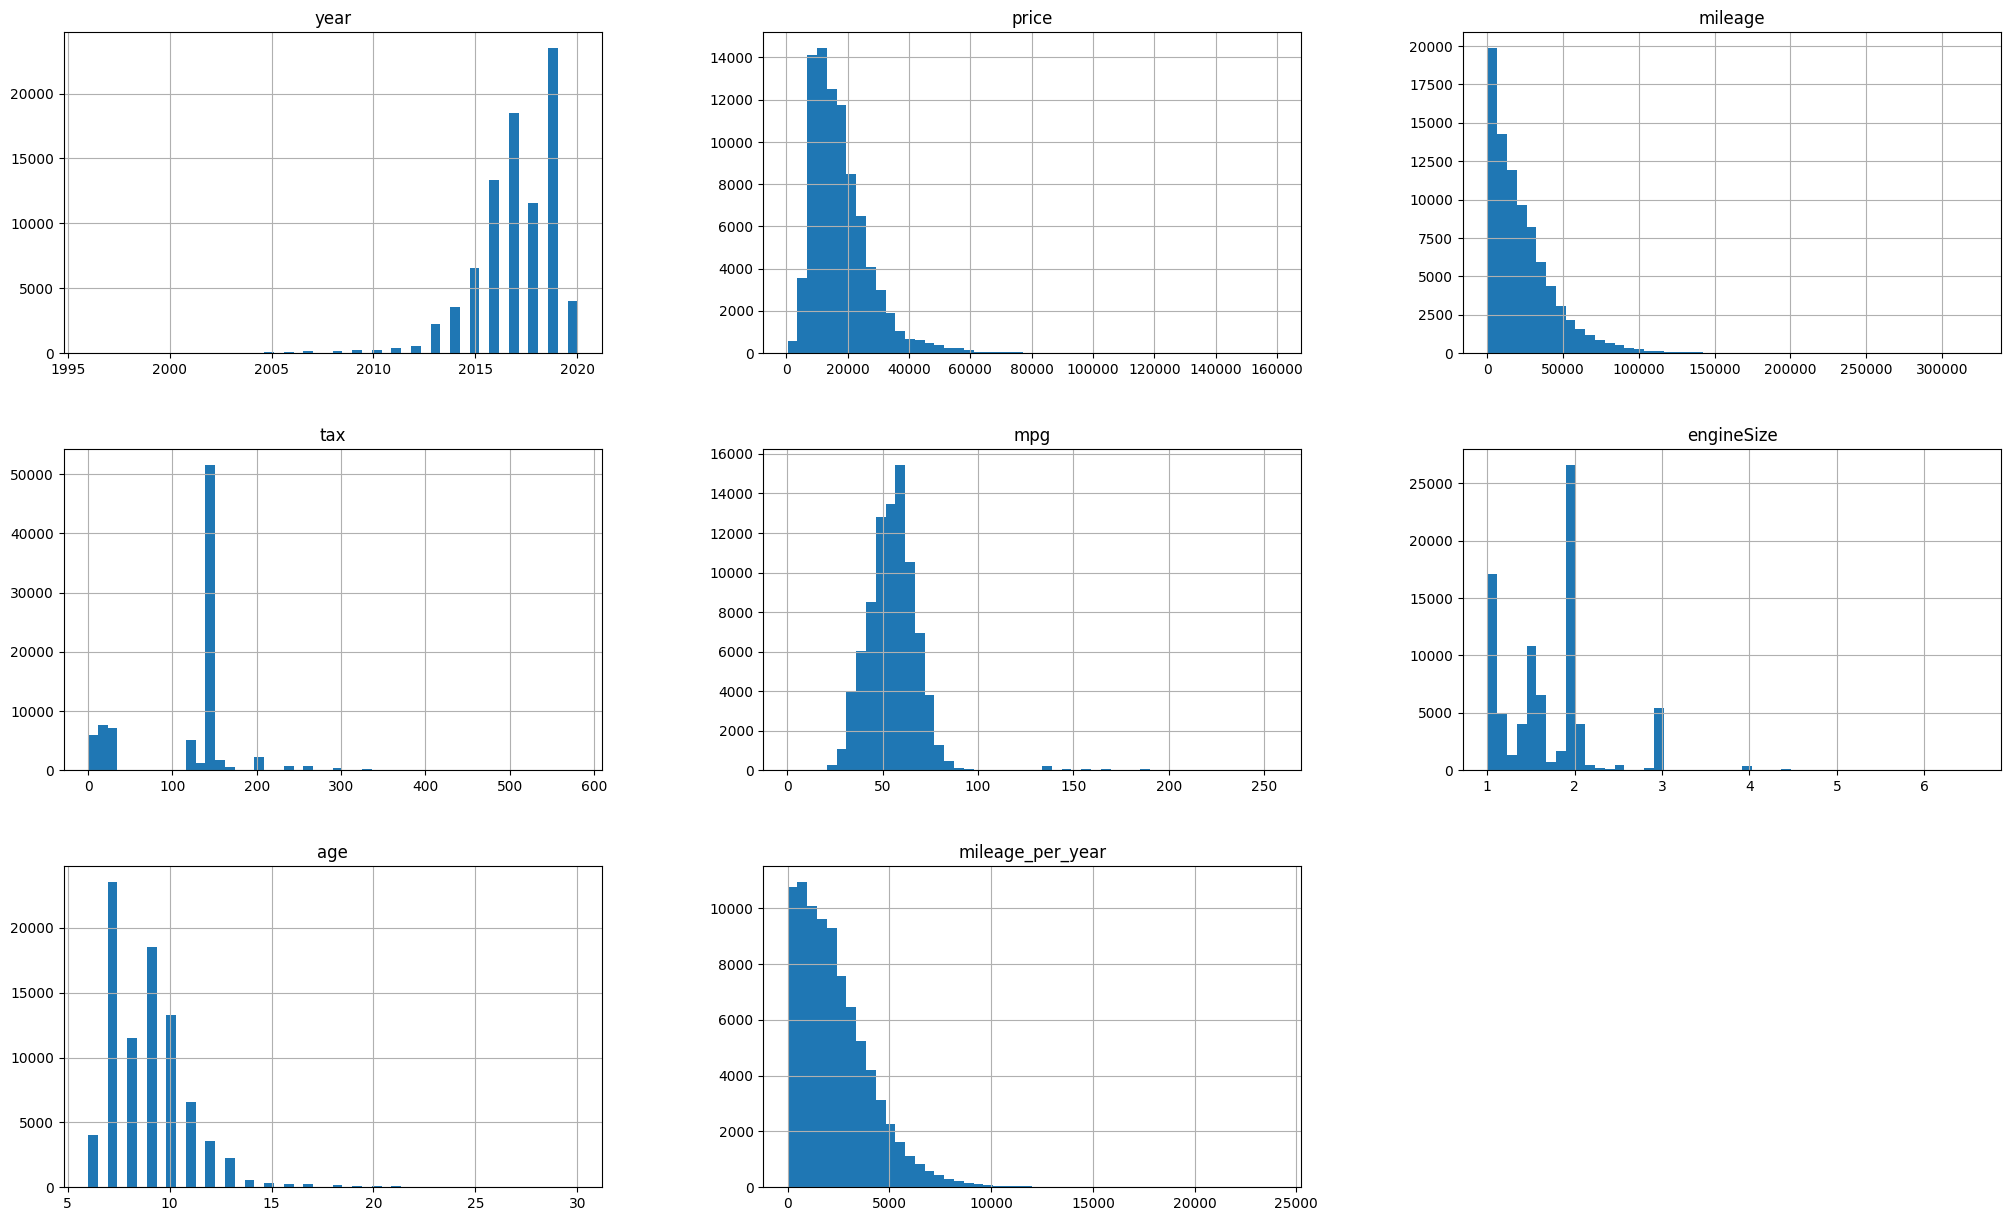

In [27]:
df.hist(bins=50,figsize=(25,15))
plt.show()

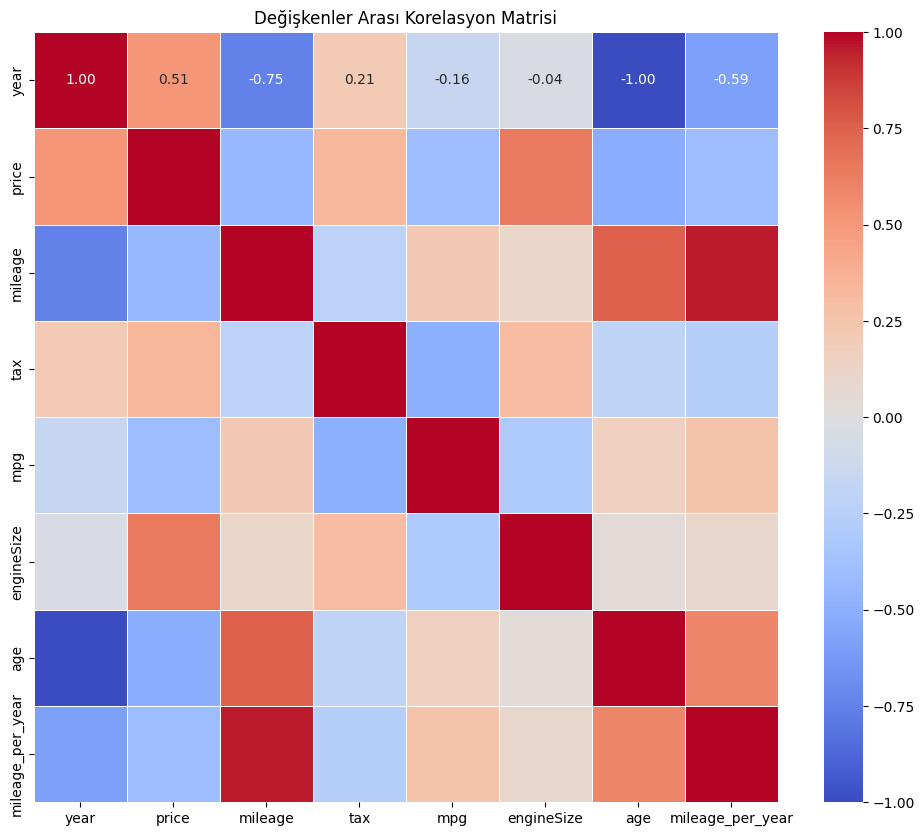

In [28]:
numeric_cols = df.select_dtypes(include=['float64', 'int64'])

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Değişkenler Arası Korelasyon Matrisi')
plt.show()

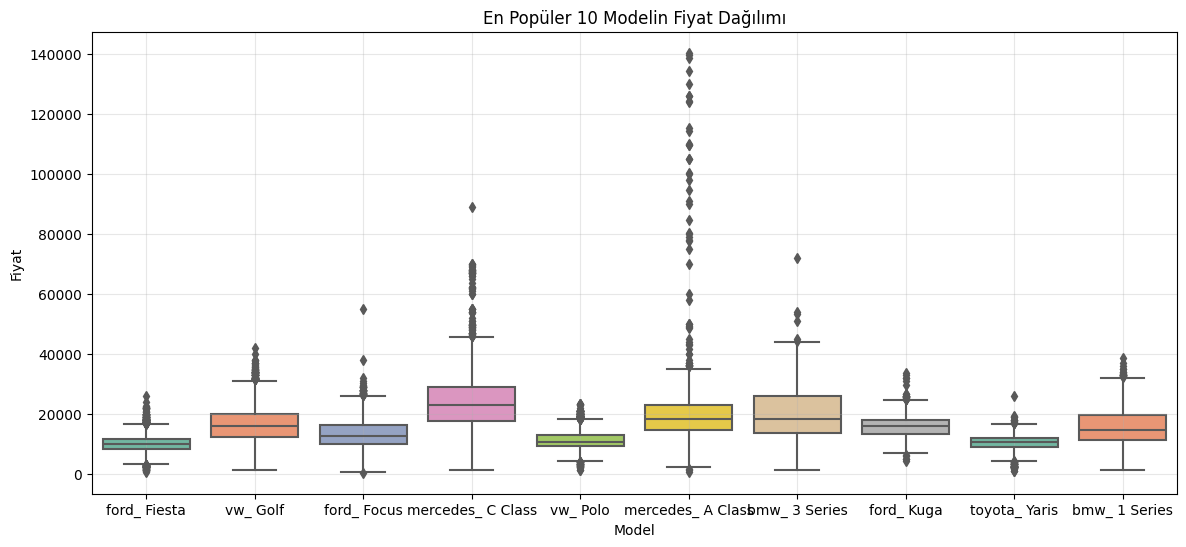

In [29]:
top_10_models = df['model'].value_counts().head(10).index

df_top_models = df[df['model'].isin(top_10_models)]

plt.figure(figsize=(14, 6))

sns.boxplot(x='model', y='price', data=df_top_models, order=top_10_models, palette='Set2')
plt.title('En Popüler 10 Modelin Fiyat Dağılımı')
plt.ylabel('Fiyat')
plt.xlabel('Model')
plt.grid(True, alpha=0.3)
plt.show()

## 5. Veri Ön İşleme

Makine öğrenmesi modelleri metin (string) verilerle çalışamaz, sadece sayıları anlar. Bu nedenle:
  **Kategorik Dönüşüm:** `model`, `transmission`, `fuelType` gibi metin verilerini **One-Hot Encoding** (get_dummies) yöntemiyle 0 ve 1'lere dönüştürüyoruz.


In [30]:
for i in df.select_dtypes(include='object').columns:
    print(df[i].value_counts())
    print('****'*20)

model
ford_ Fiesta         6537
vw_ Golf             4860
ford_ Focus          4577
mercedes_ C Class    3747
vw_ Polo             3287
                     ... 
ford_ Ranger            1
Audi_ RS7               1
Audi_ A2                1
mercedes_220            1
mercedes_200            1
Name: count, Length: 171, dtype: int64
********************************************************************************
transmission
Manual       44335
Semi-Auto    22212
Automatic    18754
Other            5
Name: count, dtype: int64
********************************************************************************
fuelType
Petrol      43985
Diesel      38041
Hybrid       3040
Other         238
Electric        2
Name: count, dtype: int64
********************************************************************************


In [31]:
top_10_models = df['model'].value_counts().head(10).index

df['model'] = df['model'].apply(lambda x: x if x in top_10_models else 'z_Other')

df = pd.get_dummies(df, columns=['model'], drop_first=True)

In [32]:
df=df[df["transmission"]!="Other"]

In [33]:
df = pd.get_dummies(df, columns=['transmission'])

In [34]:
df=df[df["fuelType"]!="Electric"]

In [35]:
df = pd.get_dummies(df, columns=['fuelType'])

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85299 entries, 0 to 15156
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     85299 non-null  int64  
 1   price                    85299 non-null  int64  
 2   mileage                  85299 non-null  int64  
 3   tax                      85299 non-null  int64  
 4   mpg                      85299 non-null  float64
 5   engineSize               85299 non-null  float64
 6   age                      85299 non-null  int64  
 7   mileage_per_year         85299 non-null  float64
 8   model_bmw_ 3 Series      85299 non-null  bool   
 9   model_ford_ Fiesta       85299 non-null  bool   
 10  model_ford_ Focus        85299 non-null  bool   
 11  model_ford_ Kuga         85299 non-null  bool   
 12  model_mercedes_ A Class  85299 non-null  bool   
 13  model_mercedes_ C Class  85299 non-null  bool   
 14  model_toyota_ Yaris      85

In [37]:
# log dönüşümünün gerekli olup olmadığını her sütun için kontrol edelim

In [38]:
for i in df.columns:
    print(i)
    print(df[i].skew())

year
-1.8085599556809515
price
2.2632679696741618
mileage
1.7804165798253193
tax
0.11577789835310787
mpg
2.55970484754254
engineSize
1.2446410045615273
age
1.808559955681043
mileage_per_year
1.326850828115134
model_bmw_ 3 Series
5.657163643807841
model_ford_ Fiesta
3.1830801733098317
model_ford_ Focus
3.9615269545849072
model_ford_ Kuga
5.948267166717951
model_mercedes_ A Class
5.515167753564301
model_mercedes_ C Class
4.450983554359664
model_toyota_ Yaris
6.1058292907929905
model_vw_ Golf
3.8225864196107655
model_vw_ Polo
4.794924276716329
model_z_Other
-0.3988257436746202
transmission_Automatic
1.3530132981639937
transmission_Manual
-0.07910279966579944
transmission_Semi-Auto
1.0919471840530228
fuelType_Diesel
0.2174347404078905
fuelType_Hybrid
5.011503572801802
fuelType_Other
18.852439037851276
fuelType_Petrol
-0.06256466079986064


In [39]:
# bu değerler arasından 1 den büyük olanlara log dönüşümü uygulayacağız(one-hot dönüşümü yaptıklarımız hariç) 

In [40]:
df['mileage'] = np.log(df['mileage'])

In [41]:
df['mpg'] = np.log(df['mpg'])

In [42]:
df['engineSize'] = np.log(df['engineSize'])

In [43]:
df['age'] = np.log(df['age'])

In [44]:
df['mileage_per_year'] = np.log(df['mileage_per_year'])

## 6. Modelleme ve Sonuçlar

In [45]:
X = df.drop("price", axis = 1)
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42)

In [46]:
X_train = X_train.astype(float)
y_train = y_train.astype(float)

In [47]:
lm = sm.OLS(y_train, X_train)

In [48]:
model = lm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                 1.003e+04
Date:                Tue, 10 Feb 2026   Prob (F-statistic):               0.00
Time:                        20:31:48   Log-Likelihood:            -6.7860e+05
No. Observations:               68239   AIC:                         1.357e+06
Df Residuals:                   68217   BIC:                         1.357e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
year                     -469.6820     55.412     -8.476      0.000    -578.290    -361.074
mileage                 -8899.6584    190.820    -46.639      0.000   -9273.666   -8525.651
tax                       -15.6876      0.381    -41.147      0.000     -16.435     -14.940
mpg                     -7862.5399    133.638    -58.835      0.000   -8124.470   -7600.609
engineSize               1.825e+04    111.720    163.395      0.000     1.8e+04    1.85e+04
age                     -1.719e+04    388.323    -44.280      0.000    -1.8e+04   -1.64e+04
mileage_per_year         8295.3017    197.847     41.928      0.000    7907.522    8683.082
model_bmw_ 3 Series       207.7491    171.861      1.209      0.227    -129.098     544.596
model_ford_ Fiesta       4244.8983    149.553     28.384      0.000    3951.775    4538.021
model_ford_ Focus        3616.7197    154.208     23.453      0.000    3314.472    3918.968
model_ford_ Kuga          196.9554    177.863      1.107      0.268    -151.657     545.567
model_mercedes_ A Class  3798.1248    170.426     22.286      0.000    3464.090    4132.160
model_mercedes_ C Class  3176.3934    158.528     20.037      0.000    2865.680    3487.107
model_toyota_ Yaris     -1302.2224    180.604     -7.210      0.000   -1656.207    -948.238
model_vw_ Golf           1023.6975    150.939      6.782      0.000     727.857    1319.538
model_vw_ Polo           3239.6117    164.180     19.732      0.000    2917.819    3561.405
model_z_Other            2733.6424    130.512     20.946      0.000    2477.839    2989.445
transmission_Automatic       6e+05   6.45e+04      9.307      0.000    4.74e+05    7.26e+05
transmission_Manual      5.979e+05   6.45e+04      9.273      0.000    4.72e+05    7.24e+05
transmission_Semi-Auto   6.007e+05   6.45e+04      9.317      0.000    4.74e+05    7.27e+05
fuelType_Diesel          4.479e+05   4.84e+04      9.263      0.000    3.53e+05    5.43e+05
fuelType_Hybrid          4.507e+05   4.83e+04      9.323      0.000    3.56e+05    5.45e+05
fuelType_Other           4.507e+05   4.84e+04      9.320      0.000    3.56e+05    5.45e+05
fuelType_Petrol          4.494e+05   4.84e+04      9.291      0.000    3.55e+05    5.44e+05
==============================================================================
Omnibus:                    58397.406   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6179943.958
Skew:                           3.598   Prob(JB):                         0.00
Kurtosis:                      49.062   Cond. No.                     4.66e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenval

In [49]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [50]:
rmse = np.sqrt(mean_squared_error(y_train, lr_model.predict(X_train)))
rmse

5041.760030790733

In [51]:
lr_model.score(X_train, y_train)

0.7553508856526219

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
rf_model = RandomForestRegressor(random_state = 42)

In [54]:
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [55]:
y_pred = rf_model.predict(X_test)

In [56]:
np.sqrt(mean_squared_error(y_test, y_pred))

2621.2100965934683

In [57]:
r2_score(y_test, y_pred)

0.931932054612842

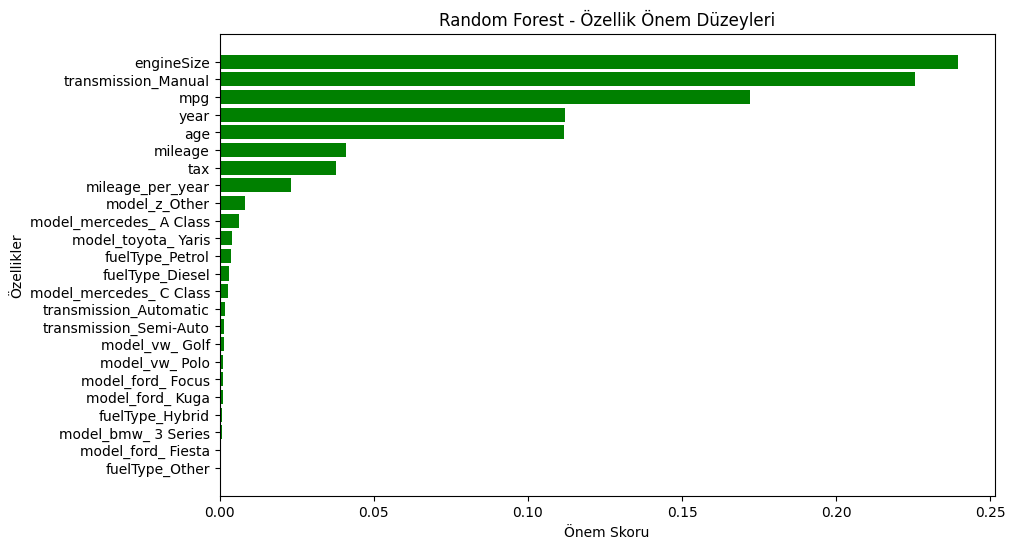

In [58]:
onem_degerleri = rf_model.feature_importances_
feature_names = X_train.columns 

df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': onem_degerleri
})

df_importance = df_importance.sort_values(by='importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(df_importance['feature'], df_importance['importance'], color='green')

plt.title('Random Forest - Özellik Önem Düzeyleri')
plt.xlabel('Önem Skoru')
plt.ylabel('Özellikler')
plt.show()

In [59]:
rf_params = {
    'max_depth': [10, 20, 30, None], 
    
    'max_features': [10, 20, 'sqrt'],
    
    'n_estimators': [200, 500]
}

In [60]:
rf_model = RandomForestRegressor(random_state = 42)

In [61]:
rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 5, 
                            n_jobs = -1)

In [62]:
rf_cv_model.fit(X_train, y_train)

In [63]:
rf_cv_model.best_params_

In [64]:
rf_tuned = RandomForestRegressor(max_depth  = 20, 
                                 max_features = 20, 
                                 n_estimators =500)

In [65]:
rf_tuned.fit(X_train, y_train)

,n_estimators,500
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,20
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [66]:
y_pred = rf_tuned.predict(X_test)

In [67]:
np.sqrt(mean_squared_error(y_test, y_pred))

2564.184159902702

In [68]:
r2_score(y_test, y_pred)

0.9348615524881944

In [69]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def check_overfitting(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    
    r2_train = r2_score(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    y_pred_test = model.predict(X_test)
    
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    print(f"TRAIN R2 Skoru: %{r2_train*100:.2f}")
    print(f"TEST  R2 Skoru: %{r2_test*100:.2f}")
    print("-" * 35)
    print(f"TRAIN RMSE Hatası: {rmse_train:.2f}")
    print(f"TEST  RMSE Hatası: {rmse_test:.2f}")
    print("-" * 35)

    fark = r2_train - r2_test
    
    if fark > 0.15: 
        print(" KRİTİK UYARI: Modelde Ciddi OVERFITTING (Ezberleme) Var!")
        print("   -> Train skoru çok yüksek ama Test skoru düşük.")
        print("   -> Çözüm: max_depth'i düşür (örn: 10-15 yap) veya min_samples_leaf'i artır.")
    elif fark > 0.05:
        print(" DİKKAT: Hafif bir ezberleme eğilimi var.")
        print("   -> Bu durum Random Forest için genelde kabul edilebilir sınırdadır.")
    else:
        print(" MÜKEMMEL: Model ezberlememiş, veriyi gerçekten öğrenmiş.")
        print("   -> Train ve Test skorları birbirine çok yakın.")

check_overfitting(rf_tuned, X_train, y_train, X_test, y_test)

TRAIN R2 Skoru: %98.28
TEST  R2 Skoru: %93.49
-----------------------------------
TRAIN RMSE Hatası: 1336.96
TEST  RMSE Hatası: 2564.18
-----------------------------------
 MÜKEMMEL: Model ezberlememiş, veriyi gerçekten öğrenmiş.
   -> Train ve Test skorları birbirine çok yakın.


## 7. Model Performanslarının İstatistiksel Karşılaştırması (A/B Testi)

Modellerin başarı metriklerine (RMSE, R2) bakarak birinin diğerinden "daha iyi" olduğunu söylemek bazen yanıltıcı olabilir. Aradaki farkın **şans eseri** mi yoksa **istatistiksel olarak anlamlı** mı olduğunu test etmek için bir Hipotez Testi (A/B Testi) uyguluyoruz.

* **H0 (Boş Hipotez):**  Random Forest ve Linear Regression modellerinin tahmin hataları arasında anlamlı bir fark yoktur.
* **H1 (Alternatif Hipotez):** İki modelin başarısı arasında istatistiksel olarak anlamlı bir fark vardır.

**Yöntem:**
1.  Önce hataların farkının normal dağılıp dağılmadığını **Shapiro-Wilk Testi** ile kontrol ediyoruz.
2.  Normal dağılıyorsa **Bağımlı T-Testi**, dağılmıyorsa **Wilcoxon Signed-Rank Testi** (parametrik olmayan) kullanarak karar veriyoruz.

In [70]:
hatalar_rf = np.abs(y_test - y_pred)
hatalar_lr = np.abs(y_test - y_pred_lr)

print(f"Random Forest Ortalama Hata: {np.mean(hatalar_rf):.2f}")
print(f"Lineer  Ortalama Hata: {np.mean(hatalar_lr):.2f}")

Random Forest Ortalama Hata: 1533.79
Lineer  Ortalama Hata: 3247.77


In [71]:
import scipy.stats as stats
test_stat, p_shapiro = stats.shapiro(hatalar_rf - hatalar_lr)
print(f"Normallik Testi P-value: {p_shapiro:.5f}")

# H0: İki modelin başarısı arasında fark YOKTUR.
# H1: İki model arasında fark VARDIR.

if p_shapiro > 0.05:
    # Veriler Normal Dağılıyorsa Bağımlı T-Testi 
    print("Test: Bağımlı T-Testi (Parametrik)")
    test_istatistigi, p_value = stats.ttest_rel(hatalar_rf, hatalar_lr)
else:
    # Veriler Normal DEĞİLSE Wilcoxon Testi [cite: 584]
    print("Test: Wilcoxon Signed-Rank Testi (Non-Parametrik)")
    test_istatistigi, p_value = stats.wilcoxon(hatalar_rf, hatalar_lr)

print(f"\n--- SONUÇ ---")
print(f"P-Value Değeri: {p_value}")

if p_value < 0.05:
    print("KARAR: H0 Reddedildi")
    if np.mean(hatalar_rf) < np.mean(hatalar_lr):
        print("Yorum: Random Forest, Lineer modelden İSTATİSTİKSEL OLARAK anlamlı derecede daha iyi.")
    else:
        print("Yorum: Fark var ama Random Forest daha kötü çıktı.")
else:
    print("KARAR: H0 Reddedilemedi.")
    print("Yorum: Rakamlar farklı görünse de, bu fark şans eseri olabilir. Random Forest'ın kesin bir üstünlüğü kanıtlanamadı.")

Normallik Testi P-value: 0.00000
Test: Wilcoxon Signed-Rank Testi (Non-Parametrik)

--- SONUÇ ---
P-Value Değeri: 0.0
KARAR: H0 Reddedildi
Yorum: Random Forest, Lineer modelden İSTATİSTİKSEL OLARAK anlamlı derecede daha iyi.


## 8. Model Açıklanabilirliği (Explainable AI - SHAP)

En iyi performansı veren Random Forest modelinin kararlarını nasıl verdiğini anlamak için **SHAP (SHapley Additive exPlanations)** yöntemini kullanıyoruz. Bu analiz bize şunları gösterir:

1.  **Feature Importance (Özellik Önemi):** Hangi özellikler (örn. age, mileage) modelin tahminini en çok etkiliyor?
2.  **Yön Analizi:** Bir özelliğin yüksek olması fiyatını artırıyor mu, azaltıyor mu?

*Aşağıdaki grafiklerde, her bir noktanın bir arabayı temsil ettiğini ve rengin özelliğin değerini (Kırmızı: Yüksek, Mavi: Düşük) gösterdiğini unutmayalım.*

In [72]:
explainer = shap.TreeExplainer(rf_tuned)
shap_values = explainer(X_test[:100])

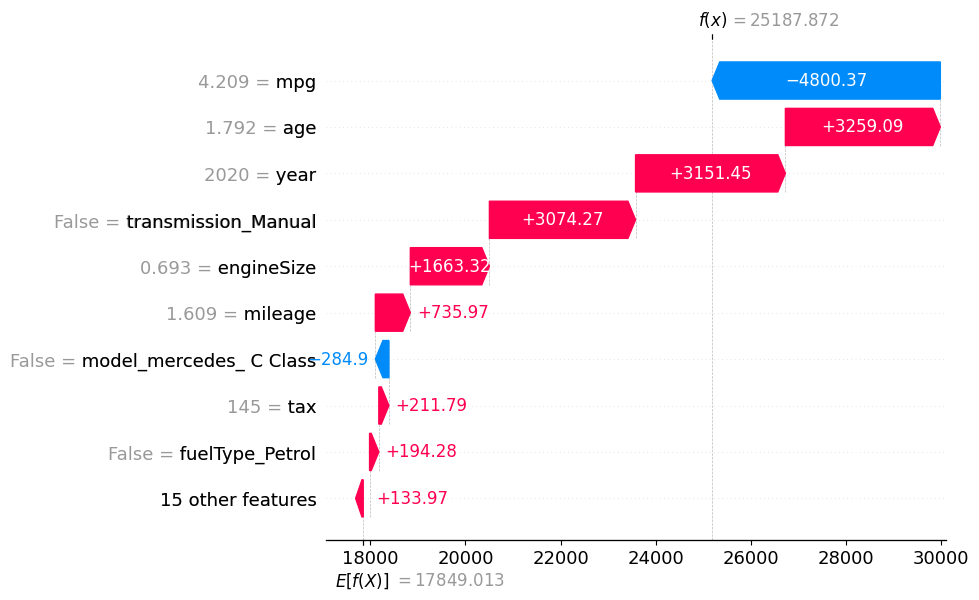

In [73]:
shap.plots.waterfall(shap_values[1])

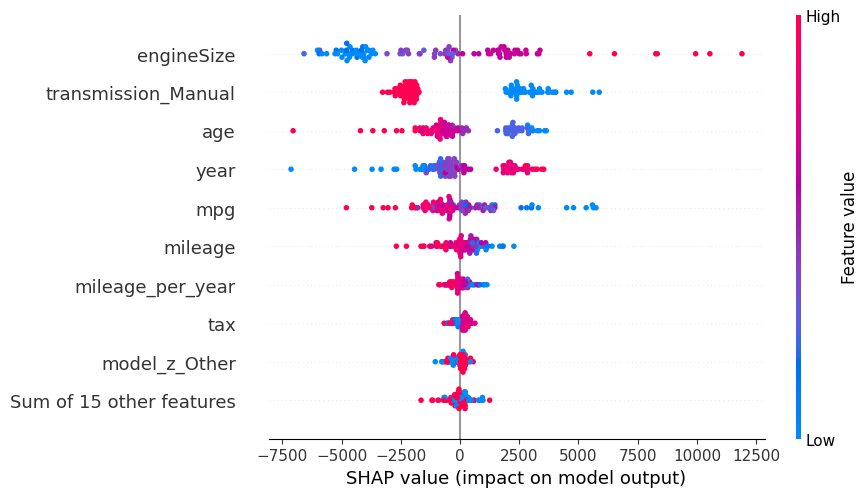

In [74]:
shap.plots.beeswarm(shap_values)

## 9. Sonuç ve Öneriler
Bu çalışmada, ikinci el araç fiyatlarını yüksek doğrulukla tahmin edebilmek amacıyla kapsamlı bir makine öğrenmesi hattı (pipeline) kurulmuştur. Geliştirilen modelin karar mekanizmaları SHAP (Açıklanabilir Yapay Zeka) teknikleriyle incelenmiş ve otomotiv piyasasının dinamikleriyle örtüşen sonuçlar elde edilmiştir.

### 1. Teknik Bulgular
* Model Performansı: Geliştirilen Random Forest Regresyon modeli, fiyat tahminlemede üstün bir başarı göstermiştir. Lineer Regresyon modelinin Ortalama Mutlak Hatası (MAE) 3247.77 birim iken, Random Forest modeli bu hatayı 1561.59 birime indirerek hatayı yaklaşık %52 oranında azaltmıştır.

* İstatistiksel Anlamlılık: Modeller arasındaki bu performans farkının şans eseri olup olmadığını test etmek için yapılan Wilcoxon Signed-Rank Testi sonucunda p-değeri 0.0000 bulunmuştur. H0 hipotezi reddedilmiş ve Random Forest modelinin Lineer modele göre istatistiksel olarak anlamlı derecede daha iyi olduğu kanıtlanmıştır.

### 2. Kritik Belirleyiciler (SHAP Analizi)
Modelin fiyat belirleme sürecini şeffaflaştıran SHAP analizine göre, araç fiyatlarını en çok etkileyen faktörler şunlardır:

* Motor Hacmi (EngineSize): En Güçlü Belirleyici. SHAP özet grafiğine göre, motor hacmi ile fiyat arasında güçlü bir pozitif ilişki vardır. Grafik incelendiğinde, yüksek motor hacmine sahip araçların (kırmızı noktalar) fiyat tahminini ciddi oranda yukarı çektiği görülmektedir.

* Vites Tipi (Transmission_Manual): Analiz sonuçları, aracın manuel vites olmasının fiyat üzerinde negatif bir baskı oluşturduğunu göstermektedir. Şanzımanın "Manuel" olması, aracın değerini düşüren en önemli ikinci faktör olarak öne çıkmaktadır (Otomatik vitesin primi yüksektir).

* Araç Yaşı (Age) ve Yıl (Year): Beklendiği üzere araç yaşı ile fiyat arasında ters orantı vardır. Araç gençleştikçe (düşük yaş değeri), SHAP değeri pozitif yönde artmakta ve tahmini fiyat yükselmektedir.

* Yakıt Tüketimi (MPG - Miles Per Gallon): Dikkat Çekici Bulgu. Veride yüksek MPG (yüksek yakıt verimliliği/az yakan araçlar) değerlerinin fiyatı düşürücü etkisi olduğu gözlemlenmiştir. Bu durum, piyasada "düşük yakıt tüketen ekonomik araçların" lüks ve yüksek performanslı araçlara kıyasla daha ucuz olmasıyla açıklanabilir.

### 3. Genel Değerlendirme
Proje sonucunda, sadece kilometre veya yılın değil, donanım özelliklerinin (motor ve vites) ikinci el araç fiyatlandırmasında çok daha kritik bir rol oynadığı veri bilimi yöntemleriyle ispatlanmıştır. Elde edilen 1561 birimlik hata payı, modelin gerçek dünya senaryolarında güvenle kullanılabileceğini göstermektedir.

## 10. Model Kayıt (Serialization)

In [75]:
final_model = rf_tuned  

model_filename = 'car_price_prediction_model.pkl'
columns_filename = 'model_columns.pkl'

joblib.dump(final_model, model_filename)

joblib.dump(X_train.columns, columns_filename)

['model_columns.pkl']